In [3]:
import pandas as pd
import pickle
import numpy as np
import sys
import os
from tqdm import tqdm
from PIL import Image
import imageio
import random
import shutil
import pydicom
import matplotlib.pyplot as plt
import glob
np.random.seed(940)

In [4]:
# Change these
MOUNT = '/Volumes/Adrian_2TB/'
BASE_PATH = os.path.join(MOUNT, 'rsna-2023-abdominal-trauma-detection')
NEW_BASE_PATH = os.path.join(MOUNT, 'rsna-2023-abdominal-trauma-detection-mini')

# Exploring Components of Dataset

``train.csv`` - Target labels for the train set. Note that patients labeled healthy may still have other medical issues, such as cancer or broken bones, that don't happen to be covered by the competition labels.
z
Need to predict that the state of each medical condition.

1. **Bowel Heath** - Healthy or Injured
2. **Extravastion Health** - Healthy of Injured
3. **Kidney Heath** - Healthy, Low Grade Injury, High Grade Injury
4. **Liver Health** - Healthy, Low Grade Injury, High Grade Injury
5. **Spleen Health** - Heathy, Low Grade Injury, High Grade Injury

```any_injury``` is a simple boolean to determine if there is an ajury at all.

In [5]:
train_csv_path = os.path.join(BASE_PATH, 'train.csv')
train_df = pd.read_csv(train_csv_path)
train_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [6]:
print(f'Number of Patients: {len(train_df)}')

inj_ratio = train_df['any_injury'].sum()/len(train_df)
print(f'Injured Ratio: {inj_ratio}')

healthy_bowel_ratio = train_df['bowel_healthy'].sum()/len(train_df)
print(f'Health Bowel Ratio: {healthy_bowel_ratio}')

healthy_extravasation_healthy_ratio = train_df['extravasation_healthy'].sum()/len(train_df)
print(f'Health Extravasation Ratio: {healthy_extravasation_healthy_ratio}')

healthy_kidney_ratio = train_df['kidney_healthy'].sum() / len(train_df)
print(f'Healthy Kidney Ratio: {healthy_kidney_ratio}')

healthy_liver_ratio = train_df['liver_healthy'].sum() / len(train_df)
print(f'Healthy Liver Ratio: {healthy_liver_ratio}')

healthy_spleen_ratio = train_df['spleen_healthy'].sum() / len(train_df)
print(f'Healthy Spleen Ratio: {healthy_spleen_ratio}')

Number of Patients: 3147
Injured Ratio: 0.2716873212583413
Health Bowel Ratio: 0.9796631712742294
Health Extravasation Ratio: 0.936447410231967
Healthy Kidney Ratio: 0.94216714331109
Healthy Liver Ratio: 0.897998093422307
Healthy Spleen Ratio: 0.8875119161105816


For each patient ID in the test set, you must predict a probability for each of the different possible injury types and degrees. The file should contain a header and have the following format:

```

patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
10102,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
10107,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
etc.

```


In [7]:
train_csv_path = os.path.join(BASE_PATH, 'train.csv')
train_df = pd.read_csv(train_csv_path)
train_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


## Metdata for Dataset

```train_series_meta.csv```: Each patient may have been scanned once or twice. Each scan contains a series of images. 

- **patient_id** - A unique ID code for each patient.
- **series_id** - A unique ID code for each scan
- **aortic_hu** - The volume of the aorta in hounsfield units. This acts as a reliable proxy for when the scan was. For a multiphasic CT scan, the higher value indicates the late arterial phase. 
- **incomplete_organ** - True if one or more organs wasn't fully covered by the scan. This label is only provided for the train set.

In [8]:
train_metadata_csv_path = os.path.join(BASE_PATH, 'train_series_meta.csv')
train_metadata_df = pd.read_csv(train_metadata_csv_path)
train_metadata_df.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


# Visualize Dicom Images

These images are going to be converted to PNGs but why not visualize them

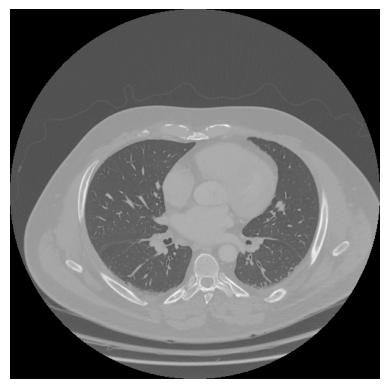

In [9]:
sample_dicom = os.path.join(BASE_PATH, 'train_images', '19','14374', '249.dcm')
dicom_data = pydicom.dcmread(sample_dicom)
image_array = dicom_data.pixel_array
plt.imshow(image_array, cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Hide the axes
plt.show()

In [10]:
# Function to convert Dicom to PNG
def convert_dicom_to_png(dicom_file_path, png_file_path, size=512):
    """
    Convert a DICOM image to a 512x512 PNG image.

    Parameters:
    dicom_file_path (str): Path to the input DICOM file.
    png_file_path (str): Path for the output PNG file.
    """

    try:
        # Load the DICOM image
        ds = pydicom.dcmread(dicom_file_path)

        # Get the image array from the DICOM dataset
        image_array = ds.pixel_array

        # Normalize the image array to 0-255 and convert to uint8 (if necessary)
        image_array = ((image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255).astype(np.uint8)

        # Resize the image to 512x512 using Pillow
        image_pil = Image.fromarray(image_array)
        image_resized = image_pil.resize((size, size), Image.LANCZOS)

        # Save the resized image as PNG using imageio
        os.makedirs(os.path.dirname(png_file_path), exist_ok=True)
        imageio.imwrite(png_file_path, image_resized)

    except Exception as e:
        print(f"An error occurred: {e}")




# Select A Subset of the Dataset

Since the dataset is too large (~400GB), randomly subsample 25% of the entire dataset to work with.

First step it randomly select our patient ids for the train, val, test split.

In [12]:
SUBSET_RATIO = 0.25
SUBSET_TRAIN_VAL_TEST_SPLIT = {'train': 0.8, 'val': 0.1, 'test': 0.1}
num_patients = len(train_df)
num_patients_subset = int(SUBSET_RATIO * num_patients)
patient_ids = train_df['patient_id'].to_numpy()
print(f'Number of patients in subset {num_patients_subset}')

# Randomly shuffle patient_ids list
np.random.shuffle(patient_ids)

num_train_patients = int(np.ceil(SUBSET_TRAIN_VAL_TEST_SPLIT['train'] * num_patients_subset))
num_val_patients = int(np.ceil(SUBSET_TRAIN_VAL_TEST_SPLIT['val'] * num_patients_subset))
num_test_patients = int(np.floor(SUBSET_TRAIN_VAL_TEST_SPLIT['test'] * num_patients_subset))
assert num_train_patients + num_val_patients + num_test_patients == num_patients_subset, "Change ceil or floor to match, lazy implementation"

subset_patient_ids = patient_ids[:num_patients_subset]
train_patients = subset_patient_ids[:num_train_patients]
val_patients = subset_patient_ids[num_train_patients:num_val_patients+num_train_patients]
test_patients = subset_patient_ids[num_val_patients+num_train_patients:]
print(f'Number of Patients in Train Subset: {len(train_patients)}')
print(f'Number of Patients in Validation Subset: {len(val_patients)}')
print(f'Number of Patients in Test Subset: {len(test_patients)}')

Number of patients in subset 786
Number of Patients in Train Subset: 629
Number of Patients in Validation Subset: 79
Number of Patients in Test Subset: 78


## Generate the Infos database file

Make a pickle file it contains information about each patient. It will have the following structure

```
train:
  patient_id:
    labels:
        bowel_healthy: Bool
        bowel_injury: Bool
        extravasation_healthy: Bool
        extravasation_injury: Bool
        kidney_healthy: Bool
        kidney_low: Bool
        liver_healthy: Bool
        liver_low: Bool
        liver_high: Bool
        spleen_healthy: Bool
        spleen_low: Bool
        spleen_high: Bool
        any_injury: Bool
    metadata:           
        series_ids:
           series_id:
                aortic_hu: Float
                incomplete_organ: Bool
val:
   ...

test:
   ...

```

In [10]:
infos_db_dict = {'train':{}, 'val':{}, 'test':{}}
patient_id_splits = {'train':train_patients, 
                     'val':val_patients, 'test':test_patients}

splits = list(infos_db_dict.keys())
for split in splits:
    for patient_id in patient_id_splits[split]:
        infos_db_dict[split][patient_id] = {}

        # labels
        labels = train_df.loc[train_df['patient_id'] == patient_id].to_dict(orient='records')[0]
        del labels['patient_id']
        infos_db_dict[split][patient_id]['labels'] = labels

        # metadata
        meta_data = train_metadata_df.loc[train_metadata_df['patient_id'] == patient_id].to_numpy()
        infos_db_dict[split][patient_id]['metadata'] = {}
        infos_db_dict[split][patient_id]['metadata']['series_ids'] = {}
        for series in meta_data:
            series_id = int(series[1])
            series_dict = {'aortic_hu': float(series[2]), 'incomplete_organ':int(series[3])}
            infos_db_dict[split][patient_id]['metadata']['series_ids'][series_id] = series_dict

In [11]:
import pprint
pprint.pprint(infos_db_dict, width=1)

{'test': {2232: {'labels': {'any_injury': 0,
                            'bowel_healthy': 1,
                            'bowel_injury': 0,
                            'extravasation_healthy': 1,
                            'extravasation_injury': 0,
                            'kidney_healthy': 1,
                            'kidney_high': 0,
                            'kidney_low': 0,
                            'liver_healthy': 1,
                            'liver_high': 0,
                            'liver_low': 0,
                            'spleen_healthy': 1,
                            'spleen_high': 0,
                            'spleen_low': 0},
                 'metadata': {'series_ids': {4213: {'aortic_hu': 163.0,
                                                    'incomplete_organ': 0}}}},
          2937: {'labels': {'any_injury': 0,
                            'bowel_healthy': 1,
                            'bowel_injury': 0,
                            'extravasati

## Generate the Sub-Dataset 

Extract image folders and copy them into new dataset structure

New folder structure:

```

rsna-2024-abdominal-trauma-detection-mini/
    - train/
       - patient_id
           - series_id
               - *.png

    - val/
       - patient_id
           - series_id
               - *.dcm
    - test/
       - patient_id
           - series_id
               - *.dcm

    - db_infos.pkl
    - dicom_tags.parquet
    - segmentations/
        - *.nii

```



In [12]:
if not os.path.exists(NEW_BASE_PATH):
    os.makedirs(NEW_BASE_PATH)
    print(f"The directory {NEW_BASE_PATH} has been created.")
else:
    print(f"The directory {NEW_BASE_PATH} already exists.")

for split in splits:
    os.makedirs(os.path.join(NEW_BASE_PATH, split) ,exist_ok=True)

# copy parquet over
old_parquet_dir = os.path.join(BASE_PATH, 'train_dicom_tags.parquet')
new_parquet_dir = os.path.join(NEW_BASE_PATH, 'dicom_tags.parquet')
shutil.copyfile(old_parquet_dir, new_parquet_dir)

# save db infos file
db_infos_pkl_dir = os.path.join(NEW_BASE_PATH, 'db_infos.pkl')
with open(db_infos_pkl_dir, 'wb') as file:  # The 'wb' argument specifies 'write binary'
    pickle.dump(infos_db_dict, file)

# copy over segmentation files
print('\nCopying Segmentations, do not exit')
if not os.path.exists(os.path.join(NEW_BASE_PATH, 'segmentations')):
    old_segmentations_dir = os.path.join(BASE_PATH, 'segmentations')
    new_segmentations_dir = os.path.join(NEW_BASE_PATH, 'segmentations')
    shutil.copytree(old_segmentations_dir, new_segmentations_dir)
print('\nDone copying segmentations')

The directory /Volumes/Adrian_2TB/rsna-2023-abdominal-trauma-detection-mini already exists.

Copying Segmentations, do not exit

Done copying segmentations


In [13]:
# Copy over the actually data
from concurrent.futures import ThreadPoolExecutor

for split in splits:
    for patient_id in tqdm(patient_id_splits[split], desc=f'Copying over {split} data ...'):
        old_patient_id_dir = os.path.join(BASE_PATH, 'train_images', str(patient_id))
        new_patient_id_dir = os.path.join(NEW_BASE_PATH, split, str(patient_id))
        # get all the dicom in folder, convert and save to pngs
        dcm_pattern = os.path.join(old_patient_id_dir, '*/*.dcm')
        dcm_paths = glob.glob(dcm_pattern)
        dcm_paths = [path for path in dcm_paths if os.path.isfile(path)]
        png_paths = [(path[:-4]+'.png').replace(BASE_PATH+'/train_images', NEW_BASE_PATH+f'/{split}') for path in dcm_paths]
        with ThreadPoolExecutor(max_workers=os.cpu_count()-2) as executor:
            futures = [executor.submit(convert_dicom_to_png, dcm, png) for dcm, png in zip(dcm_paths, png_paths)]
            for future in futures:
                try:
                    # Wait for each task to complete
                    future.result()
                except Exception as e:
                    print(f"An error occurred: {e}")

Copying over train data ...:   6%|██▏                                   | 36/629 [08:15<2:08:47, 13.03s/it]/var/folders/d_/kn8bz9pj3mj4p96xlmr2k31c0000gn/T/ipykernel_31739/4247424102.py:19: RuntimeWarning: overflow encountered in short_scalars
  image_array = ((image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255).astype(np.uint8)
Copying over test data ...: 100%|██████████████████████████████████████████| 78/78 [23:23<00:00, 18.00s/it]


In [14]:
# Size of Dataset
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

size_bytes = get_folder_size(NEW_BASE_PATH)
size_gb = size_bytes / (1024 * 1024 * 1024)  # Convert bytes to gigabytes

print(f"Sub-Dataset Size: {size_gb:.2f} GB")

Sub-Dataset Size: 95.11 GB
